In [1]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
import multiprocessing
from functools import partial
import warnings
import h5py

### OT Solver 

### Read in data from h5 file

In [3]:
# Open the HDF5 file
with h5py.File('trajectories.h5', 'r') as file:
    # List all groups and datasets to see the file structure
    def print_structure(name, obj):
        print(name, type(obj))
    file.visititems(print_structure)
    
    # Read specific datasets
    ts_data = file.get('ts_data')[:]
    xs_data = file.get('xs_data')[:]
    
    # Print original shape
    print(f"Original shape: {xs_data.shape}")  # (n_cell, n_timepoint, n_gene)
    
    # Transpose the array to get (n_gene, n_cell, n_timepoint)
    # The order parameter specifies the new order of dimensions
    scdata = np.transpose(xs_data, (1,2, 0))
    
    # Print new shape to verify
    print(f"New shape: {scdata.shape}")  # Should be (n_gene, n_cell, n_timepoint)
    
    # Now you can work with the reshaped data
    n_gene, n_cell, n_timepoint = scdata.shape
    
    # Get time grid
    Tgrid = ts_data

ts_data <class 'h5py._hl.dataset.Dataset'>
xs_data <class 'h5py._hl.dataset.Dataset'>
Original shape: (50, 30, 2)
New shape: (30, 2, 50)


### Read in data form CSV

In [2]:
def read_synthetic_data(input_dir):
    """
    Read synthetic data previously generated by SyntheticDataGeneration
    
    Parameters:
    -----------
    input_dir : str
        Directory containing the CSV files and metadata
    
    Returns:
    --------
    scdata : list of numpy.ndarray
        Loaded gene expression matrices at different time points
        Each matrix has shape (n_genes, n_cells)
    Tgrid : numpy.ndarray
        Time points grid
    A_true : numpy.ndarray
        True system matrix used in data generation
    b_true : numpy.ndarray
        True constant load vector used in data generation
    x0 : numpy.ndarray
        Initial distribution mean used in data generation
    metadata : dict
        Additional metadata about the dataset
    """
    # Load metadata
    metadata_file = os.path.join(input_dir, 'metadata.mat')
    if not os.path.exists(metadata_file):
        raise FileNotFoundError(f"Metadata file not found: {metadata_file}")
    
    # Load .mat file
    mat_data = sio.loadmat(metadata_file)
    
    # Extract variables
    metadata = {
        'n_genes': mat_data['metadata']['n_genes'][0, 0][0, 0],
        'n_timepoints': mat_data['metadata']['n_timepoints'][0, 0][0, 0],
        'n_cells': mat_data['metadata']['n_cells'][0, 0][0, 0],
        'epsilon': mat_data['metadata']['epsilon'][0, 0][0, 0]
    }
    A_true = mat_data['A_true']
    b_true = mat_data['b_true']
    x0 = mat_data['x0']
    Tgrid = mat_data['Tgrid'][0]  # Convert to 1D array
    
    n_timepoints = metadata['n_timepoints']
    n_genes = metadata['n_genes']
    
    # Initialize list for scdata
    scdata = []
    
    # Read each timepoint CSV file
    for t in range(1, n_timepoints + 1):
        filename = os.path.join(input_dir, f'timepoint_{t:03d}.csv')
        
        if not os.path.exists(filename):
            raise FileNotFoundError(f"Timepoint file not found: {filename}")
        
        # Read CSV file
        data_df = pd.read_csv(filename)
        
        # Convert DataFrame to numpy array and transpose to match MATLAB orientation
        # (genes as rows, cells as columns)
        data_matrix = data_df.values.T
        
        # Add to list
        scdata.append(data_matrix)
    
    print(f"Successfully loaded data from {input_dir}")
    
    return scdata, Tgrid, A_true, b_true, x0, metadata

In [9]:
#input_dir = "/Users/yqian46/Library/Mobile Documents/com~apple~CloudDocs/PHD/Research/GRN/GRN Inference Code/Data"  # Replace with your directory path
#scdata, Tgrid, A_true, b_true, x0, metadata = read_synthetic_data(input_dir)

# Verify the loaded data
print("\nData summary:")
print(f"Number of timepoints: {len(scdata)}")
print(f"Number of genes: {scdata[0].shape[0]}")
print(f"Number of cells: {scdata[0].shape[1]}")
print(f"Time grid: {Tgrid}")


Data summary:
Number of timepoints: 30
Number of genes: 2
Number of cells: 100
Time grid: [0, 0.05, 0.1, 0.15000000000000002, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7000000000000001, 0.7500000000000001, 0.8000000000000002, 0.8500000000000002, 0.9000000000000002, 0.9500000000000003, 1.0000000000000002, 1.0500000000000003, 1.1000000000000003, 1.1500000000000004, 1.2000000000000004, 1.2500000000000004, 1.3000000000000005, 1.3500000000000005, 1.4000000000000006, 1.4500000000000006]


### Generate synthetic data 

In [2]:
def generate_discrete_time_system_data(A_true, b_true, x0, n_timepoints, dt, n_cells, epsilon, shuffle=False):
    """
    Generate synthetic data based on the discrete-time system equation
    
    Parameters:
    -----------
    A_true : numpy array
        True system matrix
    b_true : numpy array
        True constant load vector
    x0 : numpy array
        Initial distribution mean
    n_timepoints : int
        Number of time points to generate
    n_cells : int
        Number of cells per time point
    epsilon : float
        Noise intensity
    
    Returns:
    --------
    Y_list : list of numpy arrays
        Generated gene expression matrices at different time points
    """
    n_genes = A_true.shape[0]
    Y_list = []
    t_list = []
    
    # Generate initial time point
    x0_samples = np.random.multivariate_normal(x0, np.eye(n_genes), n_cells).T
    Y_list.append(x0_samples)
    t_list.append(0)
    
    # Generate subsequent time points
    for _ in range(1, n_timepoints):
        prev_timepoint = Y_list[-1]
        
        # Propagate cells
        noise = np.sqrt(epsilon) * np.random.randn(n_genes, n_cells)
        next_timepoint = prev_timepoint + (A_true @ prev_timepoint + b_true.reshape(-1, 1) + noise) * dt
        
        Y_list.append(next_timepoint)
        t_list.append(t_list[-1]+dt)
        if shuffle:
            np.random.shuffle(Y_list[-1].T) # shuffle cell id

    
    return Y_list, t_list

Text(0, 0.5, 'Gene Value')

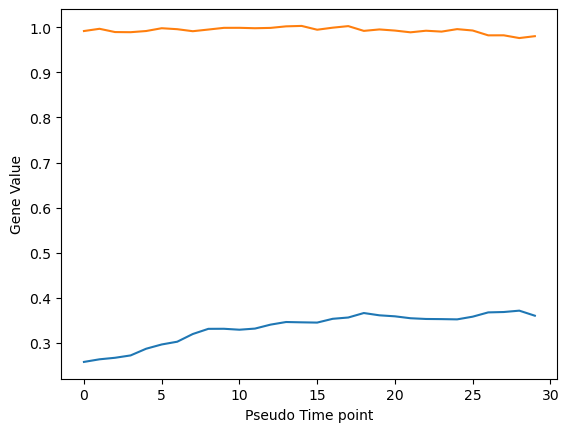

In [12]:
np.random.seed(42)
    
# Define system parameters
n_genes = 2
n_cells = 100
n_timepoints = 30
epsilon = 1
dt = 0.05

# Create true system matrix A and constant load vector b
A_true = -0.1*np.array([[1,0],[0,1]])
b_true = 0.1*np.ones(n_genes)

# Initial distribution mean
x0 = np.random.random(n_genes)

# Generate synthetic data
scdata,Tgrid = generate_discrete_time_system_data(
    A_true, b_true, x0, n_timepoints, dt, n_cells, epsilon
)

plt.plot(np.mean(scdata,2))
plt.xlabel("Pseudo Time point")
plt.ylabel("Gene Value")

In [13]:
def OTsolver_MATLABCODE(mu0, mu1, C, epsilon, uInit=None):
        """
        Optimal Transport solver using Sinkhorn algorithm with entropic regularization.

        Parameters:
        -----------
        mu0 : array_like
            Source distribution (will be reshaped to column vector)
        mu1 : array_like
            Target distribution (will be reshaped to column vector)
        C : array_like
            Cost matrix
        epsilon : float
            Regularization parameter
        uInit : array_like, optional
            Initial value for dual variable u1

        Returns:
        --------
        transport_cost : float
            The optimal transport cost
        reg_cost : float
            The regularization cost
        M : ndarray
            The optimal transport plan (matrix)
        iteration_count : int
            Number of iterations needed
        u1 : ndarray
            Final dual variable
        """
        # Reshape distributions to column vectors
        mu0 = np.reshape(mu0, (-1, 1))
        mu1 = np.reshape(mu1, (-1, 1))
        

        # Check dimensions
        if abs(mu0.shape[0] - C.shape[0]) + abs(mu1.shape[0] - C.shape[1]) >= 1:
            print('dimension error')
            print(f"mu0 dimension: {mu0.shape}")
            print(f"mu1 dimension: {mu1.shape}")
            print(f"C dimension: {C.shape}")
            return None, None, None, None, None

        # Compute Gibbs kernel
        K = np.exp(-C / epsilon)

        # Initialize dual variables
        if uInit is not None:
            u1 = np.reshape(uInit, (-1, 1))
        else:
            u1 = mu1.copy()

        u0 = mu0.copy()
        u0_old = np.ones_like(u0) * 100  # arbitrary large value
        iteration_count = 0

        # Sinkhorn's algorithm main loop
        while np.linalg.norm(np.log(u0_old + 1e-16) - np.log(u0 + 1e-16)) > 1e-3 and iteration_count < 10000:
            u0_old = u0.copy()
            u0 = mu0 / (K @ u1)  # Element-wise division
            u1 = mu1 / (K.T @ u0)  # Element-wise division, K.T is transpose
            iteration_count += 1

        # Compute optimal transport plan
        # Create diagonal matrices from vectors
        diag_u0 = np.diag(u0.flatten())
        diag_u1 = np.diag(u1.flatten())
        M = diag_u0 @ K @ diag_u1

        # Calculate transport cost
        transport_cost = np.sum(M * C)  # Element-wise product

        # Calculate regularization cost
        M_flat = M.flatten()
        # Add small constant to avoid log(0)
        log_M = np.log(M_flat + 1e-16)
        EE = M_flat * log_M

        # Filter out NaN values (which might occur from log(0))
        valid_indices = ~np.isnan(EE)
        reg_cost = np.sum(EE[valid_indices])

        return transport_cost, reg_cost, M, iteration_count, u1

### GRIT CODE

In [14]:
## Inputs
TFflag = []
branchId = []
opts=None
"""
Python implementation of GRITmodelSelect function for gene regulatory network inference

Parameters:
-----------
scdata : list of numpy arrays
    Single-cell data for each time point
Tgrid : list or numpy array
    Time points for the data
TFflag : numpy array
    Flags for transcription factors
branchId : list of numpy arrays
    Branch identifiers for each cell at each time point
opts : dict, optional
    Options for the algorithm

Returns:
--------
Multiple variables including the gene regulatory matrix A and the transport maps
"""
# Initialize output structure
out = {}

# Set default options
if opts is None:
    opts = {}

if 'epsilon' not in opts:
    opts['epsilon'] = 0.05
if 'iterations' not in opts:
    opts['iterations'] = 30
if 'zeroWeight' not in opts:
    opts['zeroWeight'] = 1
if 'disp' not in opts:
    opts['disp'] = 'basic'
if 'par' not in opts:
    opts['par'] = 0
if 'Nred' not in opts:
    opts['Nred'] = min(100, round(0.9 * scdata[0].shape[0])+1)
if 'maxReg' not in opts:
    opts['maxReg'] = 40
if 'branchWeight' not in opts:
    opts['branchWeight'] = 2
if 'signed' not in opts:
    opts['signed'] = False

# Initialize parallel processing pool if required
pool = None
if opts['par'] > 1:
    pool = multiprocessing.Pool(opts['par'])

# Initialize branch IDs if empty
if not branchId:
    branchId = []
    for jt in range(len(scdata)):
        branchId.append(np.ones((1, scdata[jt].shape[1])))

# Get dimensions
ndim = scdata[0].shape[0]  # Number of genes
nbr = branchId[0].shape[0]  # Number of branches

# Count cells in samples
ncell = np.zeros(len(scdata), dtype=int)
nzeros = 0
nelements = 0

# Process each time point
for jt in range(len(scdata)):
    ncell[jt] = scdata[jt].shape[1]
    nzeros += np.sum(scdata[jt] == 0)
    nelements += scdata[jt].size

    # Check for negative values
    if np.min(scdata[jt]) < 0 and opts['zeroWeight'] < 1:
        opts['zeroWeight'] = 1
        warnings.warn("Negative values in the gene expression data. Zero inflation will not be accounted for.")

# Process time grid
Ttot = 0
if isinstance(Tgrid, list) and all(isinstance(item, (list, np.ndarray)) for item in Tgrid):  # Multiple experiments
    Tg = Tgrid
    Tgrid = []
    indtr = []
    iaux = 0
    indw = []
    indexp = []

    for jex in range(len(Tg)):
        Tgrid.extend(Tg[jex])
        indtr.extend([(i + iaux) for i in range(len(Tg[jex])-1)])

        indw.extend([sum(ncell[:iaux]) + i for i in range(sum(ncell[iaux:iaux+len(Tg[jex])-1]))])

        indexp.extend([jex] * sum(ncell[iaux+1:iaux+len(Tg[jex])]))

        iaux += len(Tg[jex])
        Ttot += max(Tg[jex]) - min(Tg[jex])

    Tgrid = np.array(Tgrid)
    indtr = np.array(indtr)
    indw = np.array(indw)
    indexp = np.array(indexp)
else:  # Single experiment
    Tgrid = np.array(Tgrid)
    indtr = np.arange(len(scdata)-1)
    indw = np.arange(sum(ncell[:-1]))
    Ttot = max(Tgrid) - min(Tgrid)
    indexp = np.ones(sum(ncell[:-1]), dtype=int)

# Check consistency
if len(Tgrid) != len(scdata):
    raise ValueError("Time grid vector length does not match the data structure size")

# Process transcription factor flags
TFflag = np.array(TFflag).reshape(-1, 1)

if len(TFflag) < ndim and len(TFflag) > 0:
    warnings.warn("Transcription factor input is interpreted as a list of TF indices")
    TFlist = TFflag.flatten()
    TFflag = np.zeros((ndim, 1), dtype=bool)
    TFflag[TFlist.astype(int)] = True

if np.sum(TFflag) == 0:
    TFflag = np.ones((ndim, 1), dtype=bool)

# Include constant load as a "transcription factor"
TFflag = np.vstack([TFflag, np.ones((nbr, 1), dtype=bool)])

# Convert to boolean if needed
if not np.issubdtype(TFflag.dtype, np.bool_):
    TFflag = TFflag > 0

# Calculate variances
vvs = np.zeros((ndim, len(indtr)))
for jt in range(len(indtr)):
    for jbr in range(nbr):
        branch_cells = np.where(branchId[indtr[jt]+1][jbr, :] > 0)[0]
        if len(branch_cells) > 0:
            mtemp = np.mean(scdata[indtr[jt]+1][:, branch_cells], axis=1, keepdims=True)
            mtemp[np.isnan(mtemp)] = 0
            vvs[:, jt] += np.sum((scdata[indtr[jt]+1][:, branch_cells] - mtemp)**2, axis=1)

    vvs[:, jt] = vvs[:, jt] / ncell[indtr[jt]+1]
# Corrected code - explicitly handle the broadcasting
weighted_vvs = np.zeros_like(vvs)
for jt in range(len(indtr)):
    weighted_vvs[:, jt] = ncell[indtr[jt]] * vvs[:, jt]

vvs = 0.5 + 0.2 * np.sum(weighted_vvs, axis=1, keepdims=True) / np.sum(ncell[indtr]) + 0.8 * vvs
vvs = vvs**(-0.5)

# Build regression matrices
XX = np.empty((ndim + nbr, 0))
DT = np.empty(0)

for jt in range(len(indtr)):
    data_with_branch = np.vstack([scdata[indtr[jt]], branchId[indtr[jt]]])
    XX = np.hstack([XX, data_with_branch])

    dt_values = (Tgrid[indtr[jt]+1] - Tgrid[indtr[jt]])**0.5 * np.ones(ncell[indtr[jt]])
    DT = np.hstack([DT, dt_values])

YY = np.zeros((ndim, XX.shape[1]))

# Regularization weights
D = 0.01 * Ttot * np.diag(XX @ XX.T) / XX.shape[1]
D[-nbr:] = 10 * D[-nbr:]

# Reduced weights for zeros
WW = np.ones((ndim, sum(ncell)))
for jt in range(len(scdata)):
    indices = slice(sum(ncell[:jt]), sum(ncell[:jt+1]))
    WW[:, indices] = 1 - (1 - opts['zeroWeight']) * (scdata[jt] < 1e-10)

# Calculate correlations and dimension reduction
Xc = XX[:ndim, :]
indmiss = np.setdiff1d(np.arange(len(scdata)), indtr)

for im in indmiss:
    Xc = np.hstack([Xc, scdata[im]])

Xc = Xc - np.mean(Xc, axis=1, keepdims=True)


nred = min(opts['Nred'], min(Xc.shape))
    
# If matrix is large, use randomized SVD approach for efficiency
if max(Xc.shape) > 10000:
    # Randomized SVD - efficient for large matrices and when we only need top k components
    from sklearn.utils.extmath import randomized_svd
    Ured, S, _ = randomized_svd(Xc, n_components=nred, random_state=42)
else:
    # For smaller matrices, use numpy's full SVD and take top components
    U, S, _ = np.linalg.svd(Xc, full_matrices=False)
    Ured = U[:, :nred]
    S = S[:nred]

corNet = Xc @ Xc.T
sc = np.diag(corNet)**(-0.5)
corNet = sc.reshape(-1, 1) * corNet * sc
out['vars'] = (S**2) / np.sum(Xc**2)
indmiss = np.hstack([[0], indmiss])

# Scale XX by time differences
XX = DT * XX

# Calculate branch masses
branchMass = np.zeros((branchId[0].shape[0], 1))
for jt in range(len(branchId)):
    branchMass += np.sum(branchId[jt], axis=1, keepdims=True)

branchMass = branchMass / np.sum(branchMass)
brm = np.zeros((len(branchMass), len(branchId)))

for jt in range(len(branchId)):
    for jb in range(branchId[jt].shape[0]):
        branch_sum = np.sum(branchId[jt][jb, :]) / np.sum(branchId[jt], axis=1)
        if branch_sum > 0:
            brm[jb, jt] = branchMass[jb, 0] / branch_sum

if np.max(np.isinf(brm)):
    warnings.warn("Some branches are not present in all time points!")

brm[np.isinf(brm)] = 1

# Initialize iterative solution
A = np.ones((ndim, ndim+nbr))
difs = np.zeros(opts['iterations'])
J = np.zeros(opts['iterations'])
out['its'] = np.zeros((opts['iterations'], len(indtr)))

rat = [1] * len(indtr)
m_rat = 1
uFin = [1] * len(indtr)
transportMap = [None] * len(scdata)

# Prepare for main iteration loop
convergenceProblemIndicator = [0] * len(indtr)
tMap = [None] * len(indtr)
Jadd = [0] * len(indtr)
its = [0] * len(indtr)
der = [None] * len(indtr)

# Main iterative loop
for jiter in range(opts['iterations']):
    kreg = min(0.5 + 0.7 * (jiter+1) / opts['iterations'], 1)
    Aold = A.copy()
    
    # Process each transition
    for jt in range(len(indtr)):
        # Propagated and target points
        X0 = scdata[indtr[jt]] + (Tgrid[indtr[jt]+1] - Tgrid[indtr[jt]]) * A @ np.vstack([scdata[indtr[jt]], branchId[indtr[jt]]])
        X1 = scdata[indtr[jt]+1]

        # Cost matrix
        ett0 = np.ones((X0.shape[1], 1))
        ett1 = np.ones((X1.shape[1], 1))
        

        vX0 = vvs[:, jt].reshape(-1, 1) * X0
        vX1 = vvs[:, jt].reshape(-1, 1) * X1
        
        UvX0 = Ured.T @ vX0
        UvX1 = Ured.T @ vX1

        sum_UvX0_squared = np.sum(UvX0**2, axis=0).reshape(-1, 1)
        sum_UvX1_squared = np.sum(UvX1**2, axis=0)

        
        C = sum_UvX0_squared @ ett1.T - 2 * UvX0.T @ UvX1 + ett0 @ sum_UvX1_squared.reshape(1, -1)

        # Adjust costs for branch transitions
        branch_jumps = (branchId[indtr[jt]].T @ branchId[indtr[jt]+1] == 0)
        C = C * (1 + (opts['branchWeight'] - 1) * branch_jumps)

        # Mass distributions
        br_norm_0 = branchId[indtr[jt]] / np.sum(branchId[indtr[jt]], axis=1, keepdims=True)
        br_norm_1 = branchId[indtr[jt]+1] / np.sum(branchId[indtr[jt]+1], axis=1, keepdims=True)

        mu0 = np.sum(br_norm_0 * brm[:, indtr[jt]].reshape(-1, 1), axis=0)
        mu1 = np.sum(br_norm_1 * brm[:, indtr[jt]+1].reshape(-1, 1), axis=0)

        mu0 = mu0 / np.sum(mu0)
        mu1 = mu1 / np.sum(mu1)

        if jiter == 0:
            uInit = mu1
        else:
            uInit = uFin[jt]

        # Solve optimal transport problem
        epsloc = opts['epsilon']
        failInd = True
        failedSinkhornIterations = -1

        M = None
        uFinal = None
        transport_cost = 0
        reg_cost = 0
        iteration_count = 0

        while failInd and failedSinkhornIterations < 10:
            transport_cost, reg_cost, M, iteration_count, uFinal =  OTsolver_MATLABCODE(mu0, mu1, C, epsloc * np.median(C), uInit)
            failInd = np.sum(np.isnan(M)) > 0
            epsloc = 1.5 * epsloc
            failedSinkhornIterations += 1

        if jiter == opts['iterations'] - 1 and failedSinkhornIterations > 0:
            convergenceProblemIndicator[jt] = 1

        tMap[jt] = M
        uFin[jt] = uFinal
        M = M / np.sum(M, axis=1, keepdims=True)
        Jadd[jt] = transport_cost + opts['epsilon'] * np.median(C) * reg_cost
        its[jt] = iteration_count

        # Estimate derivatives
        ww_slice = WW[:, sum(ncell[:indtr[jt]]):sum(ncell[:indtr[jt]+1])]

        M_product = ww_slice @ M
        X1M = X1 @ M.T

        der[jt] = ((X1M / M_product) - scdata[indtr[jt]]) / (Tgrid[indtr[jt]+1] - Tgrid[indtr[jt]])**0.5

    # Collect derivatives
    iaux = 0
    for jt in range(len(indtr)):
        YY[:, iaux:iaux + der[jt].shape[1]] = der[jt]
        J[jiter] += Jadd[jt]
        iaux += der[jt].shape[1]
        transportMap[indtr[jt]] = tMap[jt]
        out['its'][jiter, jt] = its[jt]

    # Solve for A using regression
    Anew = np.zeros_like(A)

    for jg in range(ndim):
        # Set of regressors are the TFs and the target gene itself
        TFloc = TFflag.copy().flatten()
        TFloc[jg] = True

        WV = np.zeros(YY.shape[1])
        iaux = 0
        for jt in range(len(indtr)):
            WV[iaux:iaux + ncell[indtr[jt]]] = vvs[jg, jt]**2
            iaux += ncell[indtr[jt]]

        # Weight matrices
        W_diag = WV * WW[jg, indw]
        XX_TF = XX[TFloc, :]

        # Weighted regression with regularization
        weighted_XX = XX_TF * W_diag
        weighted_YY = YY[jg, :] * W_diag

        reg_matrix = weighted_XX @ XX_TF.T + np.diag(D[TFloc])
        Anew[jg, TFloc] = weighted_YY @ XX_TF.T @ np.linalg.inv(reg_matrix)
        

    # Regularized update
    A = (1 - kreg) * Aold + kreg * Anew
    
    # Check progress
    difs[jiter] = np.sqrt(np.sum((A - Aold)**2))

    if opts['disp'] == 'all':
        print(f"Iteration {jiter+1}/{opts['iterations']} done.")

# Final A is the unregularized one
A = Anew

# Check for and report about convergence problems
expnr = 0
for jt in range(len(convergenceProblemIndicator)):
    if convergenceProblemIndicator[jt] == 1:
        if expnr == 0:
            warnings.warn("Convergence problems detected and regularisation increased")
            print("Check the following matrices for outliers:")

        expnr = 1 + indtr[jt] - jt
        tpnr = indtr[jt] - indmiss[expnr]
        print(f"* Experiment {expnr}, time points {tpnr} and {tpnr+1}")

# Clean up pool if it was created
if pool is not None:
    pool.close()
    pool.join()

if opts['disp'] != 'off':
    print("Model identification complete.")

OUTPUT = [XX, YY, transportMap, J, A, D, WW, corNet, indw, indexp, TFflag, difs, out, opts]

Model identification complete.


In [15]:
A

array([[-0.63814302, -0.04821862,  0.32908781],
       [-0.02445814, -0.53298011,  0.52895978]])

In [11]:
kreg

0.9666666666666666